# Assignment 2: Convolutional Neural Networks and AutoML
---

# Import Required Libraries
Import the necessary libraries, including PyTorch and the chosen hyperparameter optimization library.

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from support import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from model import SimpleCNN
from train_test_optimize import train_model, test_model, objective_with_cv
from functools import partial

In [2]:
# Define global parameters
EPOCHS = 10
N_TRIALS = 5
MODEL = SimpleCNN
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cuda


# Load and Preprocess the Wefabricate Dataset
Load the Wefabricate dataset and preprocess it for use with a CNN.

In [3]:
train_data, test_data = load_dataset()

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

Train data: 136
Test data: 34


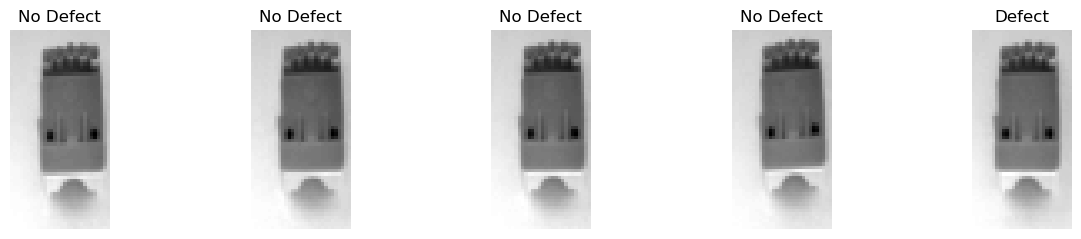

In [4]:
# Visualize data with their labels

# Define the class labels 
class_labels = ["Defect", "No Defect"]

# Get a batch of training data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
images, labels = next(iter(train_loader))

# Create a grid of the images and print the labels
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')
    plt.title(class_labels[labels[i]])
    
plt.show()

# Define the CNN Model
Define a CNN to classify product images in the Wefabricate dataset.

In [5]:
# Instantiate the network
model = SimpleCNN()

# Train the CNN Model
Train the CNN model on the training set.

In [6]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Move the model to the device
model.to(DEVICE)

# Train the model
train_losses, val_losses = train_model(model, train_data, criterion, optimizer, DEVICE, n_epochs=1, model_name="initial_model")

Training Epoch 1/1: 100%|██████████| 2/2 [00:21<00:00, 10.70s/it]


Epoch 1, Train Loss: 0.8934, Val Loss: 0.6521
Finished Training


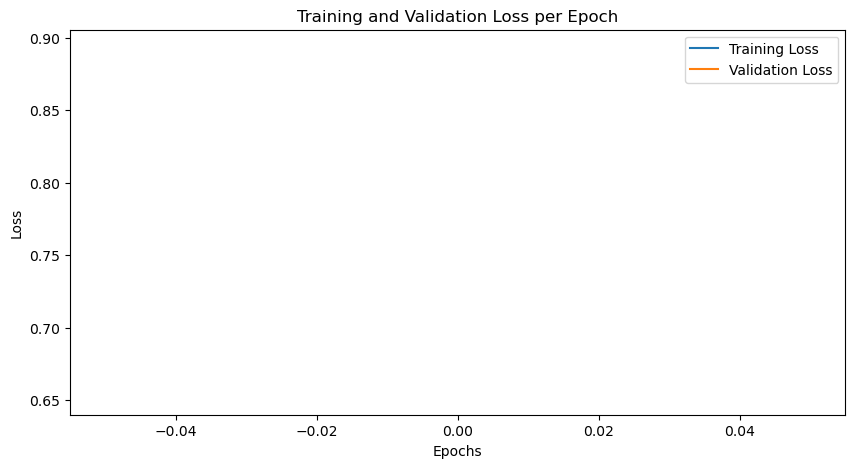

In [7]:
# Visualize the training loss over epochs
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss per Epoch")
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test the CNN Model
Test the trained CNN model on the test set.

In [8]:
# Test model on the test data and get metrics
accuracy, precision, recall, f1 = test_model(model, test_data, DEVICE)

# Visualize the metrics in a table
metrics = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
})

print(metrics)

Testing: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]

   Accuracy  Precision  Recall        F1
0      50.0        0.5     1.0  0.666667


# Hyperparameter Selection

#### 1)Learning Rate

**Importance:**  
The learning rate is fundamental as it determines how much to update the model's weights based on the error each time the model weights are updated. If set too high, the model might overshoot the minimum, leading to erratic behaviors. If too low, the model could take too long to converge or might get stuck in a local minimum.

**Relevance to Wefabricate:**  
Given that we are dealing with a small dataset (136 training images), an optimal learning rate is crucial to ensure efficient convergence without overshooting, as CNNs are sensitive to this parameter in such scenarios.

#### 2)Batch Size

**Importance:**  
The batch size affects the stability of the training process. Larger batch sizes result in smoother (less noisy) gradient estimates, but are computationally more demanding and can lead to poorer generalization. Smaller batches can offer a regularizing effect and lower generalization error.

**Relevance to Wefabricate:**  
Adjusting the batch size can help balance between computation efficiency and model performance, especially when resources are limited or when the dataset is small, as is the case in the Wefabricate dataset.

#### 3)Dropout rate

**Importance:**
This parameter controls the fraction of neurons that are randomly dropped out during training to prevent overfitting. A higher dropout rate means more neurons are ignored during each forward and backward pass, which helps in regularizing the model and improving its generalization capabilities. However, if the dropout rate is too high, the model might underfit, failing to learn important patterns in the data.

**Relevance to Wefabricate:**
Optimal dropout rate setting ensures that the model remains robust and generalizes well to new, unseen images by preventing it from memorizing the noise in the training data. This is particularly important given the limited data available, as it helps the model learn meaningful patterns without overfitting.

#### 4)Weight Decay

**Importance:**  
Weight decay (L2 regularization) helps prevent overfitting by penalizing large weights. This regularization method encourages simpler models that may generalize better on unseen data.

**Relevance to Wefabricate:**  
With a relatively small dataset and a potentially complex model, weight decay can help maintain the balance between bias and variance, thus improving the model's general performance on new, unseen images.

#### 5)Optimizer

**Importance:**  
The choice of optimizer can significantly affect the training speed and quality of the final model. Different optimizers can manage different types of data and architectures more effectively, with some being better at handling noisy gradients or avoiding local minima.

**Relevance to Wefabricate:**  
Given the task's sensitivity to hyperparameter settings due to the small data size, choosing the right optimizer (like Adam, which is generally robust, or SGD, which might benefit from fine-grained control over learning momentum) can lead to better or faster convergence in training the CNN.


# 5-Fold Cross-Validation Hyperparameter Optimization with Optuna
Perform 5-fold cross-validation on the training set to calculate the validation accuracy for the hyperparameters.

In [9]:
# Create the objective function with partial
objective = partial(objective_with_cv, n_epochs=EPOCHS, model_class=MODEL, train_data=train_data, device=DEVICE)

In [10]:
# Random search with Optuna
study_random = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study_random.optimize(objective, n_trials=N_TRIALS)
best_params_random = study_random.best_trial.params

[I 2024-05-28 19:02:51,524] A new study created in memory with name: no-name-cba18f14-dcd9-4099-a807-781a97387d35
[I 2024-05-28 19:17:42,077] Trial 0 finished with value: 49.62962962962963 and parameters: {'learning_rate': 0.005274506240010375, 'batch_size': 64, 'dropout_rate': 0.21240165342183703, 'weight_decay': 4.7719987999563396e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 49.62962962962963.
[I 2024-05-28 19:32:08,908] Trial 1 finished with value: 91.11111111111111 and parameters: {'learning_rate': 0.006693811869754288, 'batch_size': 32, 'dropout_rate': 0.060910142743828055, 'weight_decay': 5.538586123581123e-05, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 91.11111111111111.
[I 2024-05-28 19:46:52,049] Trial 2 finished with value: 48.88888888888889 and parameters: {'learning_rate': 0.0016995095557911593, 'batch_size': 64, 'dropout_rate': 0.15268762199345703, 'weight_decay': 0.00037873058301119995, 'optimizer': 'SGD'}. Best is trial 1 with value: 91.11111111111111

In [11]:
# TPE search with Optuna
study_tpe = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study_tpe.optimize(objective, n_trials=N_TRIALS)
best_params_tpe = study_tpe.best_trial.params

[I 2024-05-28 20:16:35,854] A new study created in memory with name: no-name-5ae061f8-8ca0-4af0-aa85-f6c4c6d3ad84
[I 2024-05-28 20:31:52,856] Trial 0 finished with value: 59.62962962962963 and parameters: {'learning_rate': 9.778797207115642e-05, 'batch_size': 128, 'dropout_rate': 0.2484039229318648, 'weight_decay': 0.0007344181323836014, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 59.62962962962963.
[I 2024-05-28 20:46:17,861] Trial 1 finished with value: 77.77777777777779 and parameters: {'learning_rate': 0.00017895960964480894, 'batch_size': 32, 'dropout_rate': 0.47297937592939093, 'weight_decay': 0.0020200231593964966, 'optimizer': 'Adam'}. Best is trial 1 with value: 77.77777777777779.
[I 2024-05-28 21:00:43,328] Trial 2 finished with value: 70.37037037037037 and parameters: {'learning_rate': 0.00640322906300878, 'batch_size': 32, 'dropout_rate': 0.07513664042189777, 'weight_decay': 0.00010869391897818603, 'optimizer': 'SGD'}. Best is trial 1 with value: 77.77777777777779.

# Compare Results Before and After Hyperparameter Optimization
Compare the results obtained before and after automatic hyperparameter optimization in terms of accuracy.

In [12]:
# Before optimization
default_model = SimpleCNN().to(DEVICE)
default_optimizer = optim.Adam(default_model.parameters(), lr=0.001, weight_decay=0.0001)
default_train_losses, default_val_losses = train_model(default_model, train_data, criterion, default_optimizer, DEVICE, n_epochs=EPOCHS, model_name="default_model")
default_accuracy = test_model(default_model, test_data, DEVICE)

# After optimization (Random search)
optimized_model_random = SimpleCNN(dropout_rate=best_params_random['dropout_rate']).to(DEVICE)
optimized_optimizer_random = getattr(optim, best_params_random['optimizer'])(optimized_model_random.parameters(), lr=best_params_random['learning_rate'], weight_decay=best_params_random['weight_decay'])
optimized_train_losses_random, optimized_val_losses_random = train_model(optimized_model_random, train_data, criterion, optimized_optimizer_random, DEVICE, n_epochs=EPOCHS, model_name="optimized_model_random")
optimized_accuracy_random = test_model(optimized_model_random, test_data, DEVICE)

# After optimization (TPE search)
optimized_model_tpe = SimpleCNN(dropout_rate=best_params_tpe['dropout_rate']).to(DEVICE)
optimized_optimizer_tpe = getattr(optim, best_params_tpe['optimizer'])(optimized_model_tpe.parameters(), lr=best_params_tpe['learning_rate'], weight_decay=best_params_tpe['weight_decay'])
optimized_train_losses_tpe, optimized_val_losses_tpe = train_model(optimized_model_tpe, train_data, criterion, optimized_optimizer_tpe, DEVICE, n_epochs=EPOCHS, model_name="optimized_model_tpe")
optimized_accuracy_tpe = test_model(optimized_model_tpe, test_data, DEVICE)

print(f'Default model accuracy: {default_accuracy}%')
print(f'Optimized model accuracy (Random search): {optimized_accuracy_random}%')
print(f'Optimized model accuracy (TPE search): {optimized_accuracy_tpe}%')

Training Epoch 1/10: 100%|██████████| 2/2 [00:19<00:00,  9.63s/it]


Epoch 1, Train Loss: 0.8889, Val Loss: 0.6993


Training Epoch 2/10: 100%|██████████| 2/2 [00:19<00:00,  9.59s/it]


Epoch 2, Train Loss: 0.8019, Val Loss: 0.7223


Training Epoch 3/10: 100%|██████████| 2/2 [00:19<00:00,  9.53s/it]


Epoch 3, Train Loss: 0.4901, Val Loss: 0.7067


Training Epoch 4/10: 100%|██████████| 2/2 [00:19<00:00,  9.64s/it]


Epoch 4, Train Loss: 0.4839, Val Loss: 0.6671


Training Epoch 5/10: 100%|██████████| 2/2 [00:19<00:00,  9.59s/it]


Epoch 5, Train Loss: 0.4937, Val Loss: 0.6781


Training Epoch 6/10: 100%|██████████| 2/2 [00:19<00:00,  9.53s/it]


Epoch 6, Train Loss: 0.3827, Val Loss: 0.7395


Training Epoch 7/10: 100%|██████████| 2/2 [00:19<00:00,  9.55s/it]


Epoch 7, Train Loss: 0.3992, Val Loss: 0.7718


Training Epoch 8/10: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]


Epoch 8, Train Loss: 0.3385, Val Loss: 0.7910


Training Epoch 9/10: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]


Epoch 9, Train Loss: 0.3815, Val Loss: 0.8127


Training Epoch 10/10: 100%|██████████| 2/2 [00:19<00:00,  9.54s/it]


Epoch 10, Train Loss: 0.4099, Val Loss: 0.8204
Finished Training


Training Epoch 1/10: 100%|██████████| 2/2 [00:19<00:00,  9.60s/it]


Epoch 1, Train Loss: 1.4811, Val Loss: 19.4797


Training Epoch 2/10: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]


Epoch 2, Train Loss: 1.0328, Val Loss: 2.8282


Training Epoch 3/10: 100%|██████████| 2/2 [00:19<00:00,  9.54s/it]


Epoch 3, Train Loss: 0.3757, Val Loss: 3.4875


Training Epoch 4/10: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]


Epoch 4, Train Loss: 0.2952, Val Loss: 0.4008


Training Epoch 5/10: 100%|██████████| 2/2 [00:19<00:00,  9.53s/it]


Epoch 5, Train Loss: 0.2119, Val Loss: 1.2973


Training Epoch 6/10: 100%|██████████| 2/2 [00:19<00:00,  9.54s/it]


Epoch 6, Train Loss: 0.2114, Val Loss: 0.1702


Training Epoch 7/10: 100%|██████████| 2/2 [00:19<00:00,  9.50s/it]


Epoch 7, Train Loss: 0.0999, Val Loss: 0.3538


Training Epoch 8/10: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]


Epoch 8, Train Loss: 0.0796, Val Loss: 0.4815


Training Epoch 9/10: 100%|██████████| 2/2 [00:19<00:00,  9.63s/it]


Epoch 9, Train Loss: 0.0440, Val Loss: 0.3540


Training Epoch 10/10: 100%|██████████| 2/2 [00:19<00:00,  9.55s/it]


Epoch 10, Train Loss: 0.0418, Val Loss: 0.2946
Finished Training


Training Epoch 1/10: 100%|██████████| 2/2 [00:19<00:00,  9.54s/it]


Epoch 1, Train Loss: 0.7493, Val Loss: 0.7388


Training Epoch 2/10: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]


Epoch 2, Train Loss: 0.7370, Val Loss: 0.8982


Training Epoch 3/10: 100%|██████████| 2/2 [00:19<00:00,  9.51s/it]


Epoch 3, Train Loss: 0.8742, Val Loss: 1.0925


Training Epoch 4/10: 100%|██████████| 2/2 [00:19<00:00,  9.55s/it]


Epoch 4, Train Loss: 0.5601, Val Loss: 1.3226


Training Epoch 5/10: 100%|██████████| 2/2 [00:19<00:00,  9.61s/it]


Epoch 5, Train Loss: 0.5713, Val Loss: 1.4796


Training Epoch 6/10: 100%|██████████| 2/2 [00:19<00:00,  9.53s/it]


Epoch 6, Train Loss: 0.5328, Val Loss: 1.6302


Training Epoch 7/10: 100%|██████████| 2/2 [00:19<00:00,  9.52s/it]


Epoch 7, Train Loss: 0.6184, Val Loss: 1.6535


Training Epoch 8/10: 100%|██████████| 2/2 [00:19<00:00,  9.55s/it]


Epoch 8, Train Loss: 0.5759, Val Loss: 1.7930


Training Epoch 9/10: 100%|██████████| 2/2 [00:19<00:00,  9.58s/it]


Epoch 9, Train Loss: 0.5286, Val Loss: 1.8701


Training Epoch 10/10: 100%|██████████| 2/2 [00:19<00:00,  9.54s/it]


Epoch 10, Train Loss: 0.5701, Val Loss: 1.9649
Finished Training


Testing: 100%|██████████| 1/1 [00:05<00:00,  5.25s/it]

Default model accuracy: (50.0, 0.5, 1.0, 0.6666666666666666)%
Optimized model accuracy (Random search): (73.52941176470588, 0.6538461538461539, 1.0, 0.7906976744186046)%
Optimized model accuracy (TPE search): (50.0, 0.0, 0.0, 0.0)%



c:\Users\20191678\AppData\Local\anaconda3\envs\torch-gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


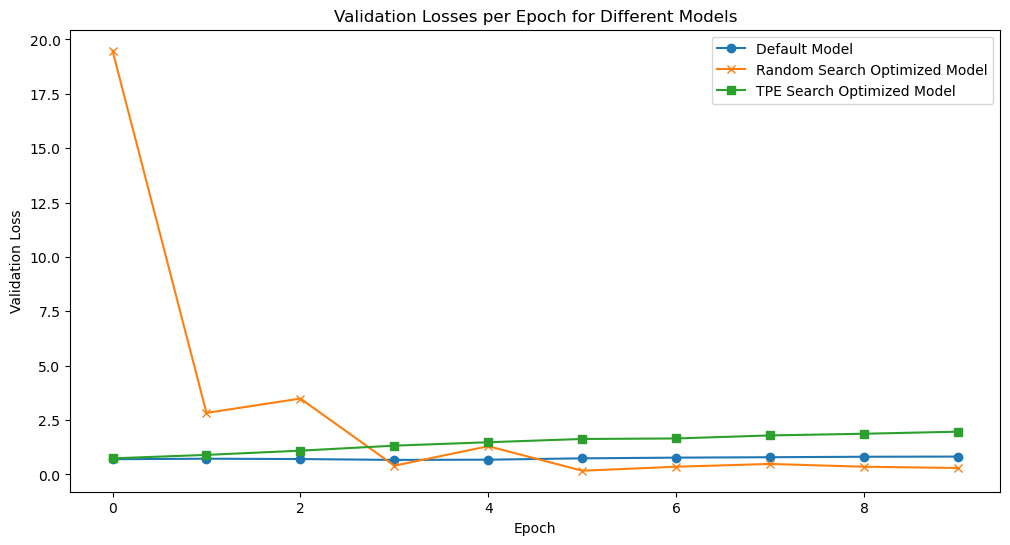

In [13]:
# Plot the validation losses for each model
plt.figure(figsize=(12, 6))

# Plot validation losses for the default model
plt.plot(default_val_losses, label='Default Model', linestyle='-', marker='o')

# Plot validation losses for the random search optimized model
plt.plot(optimized_val_losses_random, label='Random Search Optimized Model', linestyle='-', marker='x')

# Plot validation losses for the TPE search optimized model
plt.plot(optimized_val_losses_tpe, label='TPE Search Optimized Model', linestyle='-', marker='s')

# Add titles and labels
plt.title('Validation Losses per Epoch for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

# Show the plot
plt.show()
